# CS4035 - Cyber Data Analytics
## Lab 3 

### Submit on brightspace (zip file with the name Group_xx.zip)
(i) This jupyter file completed with code, plots, figures and report for each question. Additional plots and figures can be created for explanation before the end of each main question. Lab 3 contains 4 main questions + 1 bonus. Write the code or explanation below each sub question. For the explantions, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.
(ii) A PDF or a Word report for the assignment. Create a report from the plots, figures, tables and the write-up that you provide in this jupyter file. The report will be used as a proof for page limit. 
(iii) The libraries needed to run this file. 

Your peers should be able to use the readme section for instructions and be able to run this file. 

In [105]:
# If this cell does not work try running `pip install nbformat`

# import io
import nbformat

nb = nbformat.read("Lab3.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 802


## Group Number :

## Student 1 
### Name : Athanasios Georgoutsos
### ID : 6015883

## Student 2
### Name : Amar Mesic
### ID : 5106117

## Readme - Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

In [62]:
# libraries used in this lab assignment
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from nltk import ngrams

# paths to data files for each scenario
path9 = 'cda-lab3-botnet-detection/dataset_9/capture20110817.binetflow'
path10 = 'cda-lab3-botnet-detection/dataset_10/capture20110818.binetflow'
path11 = 'cda-lab3-botnet-detection/dataset_11/capture20110818-2.binetflow'
path12 = 'cda-lab3-botnet-detection/dataset_12/capture20110819.binetflow'

## 1. Familiarization and discretization task – 1 A4 (5 Points)

In [2]:
data = pd.read_csv(path10)
data.head()

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,2011/08/18 10:21:46.633335,1.060248,tcp,93.45.239.29,1611,->,147.32.84.118,6881,S_RA,0.0,0.0,4,252,132,flow=Background-TCP-Attempt
1,2011/08/18 10:19:49.027650,279.349152,tcp,62.240.166.118,1031,<?>,147.32.84.229,13363,SRPA_PA,0.0,0.0,15,1318,955,flow=Background-TCP-Attempt
2,2011/08/18 10:22:07.160628,166.390015,tcp,147.32.86.148,58067,->,66.235.132.232,80,SR_SA,0.0,0.0,3,212,134,flow=Background-TCP-Established
3,2011/08/18 10:26:02.052163,1.187083,tcp,147.32.3.51,3130,->,147.32.84.46,10010,S_RA,0.0,0.0,4,244,124,flow=Background-TCP-Attempt
4,2011/08/18 10:26:52.226748,0.980571,tcp,88.212.37.169,3134,->,147.32.84.118,6881,S_RA,0.0,0.0,4,244,124,flow=Background-TCP-Attempt


In [3]:
# check unique labels
# we will want to filter out background netflows later
print(len(data['Label'].unique()), list(data['Label'].unique()))

# check unique values for specific features
# label encoder to be used on these
print(len(data['Proto'].unique()), list(data['Proto'].unique()))
print(len(data['Dir'].unique()), list(data['Dir'].unique()))
print(len(data['State'].unique()), list(data['State'].unique()))
print(len(data['sTos'].unique()), list(data['sTos'].unique()))
print(len(data['dTos'].unique()), list(data['dTos'].unique()))

111 ['flow=Background-TCP-Attempt', 'flow=Background-TCP-Established', 'flow=Background-Established-cmpgw-CVUT', 'flow=To-Background-CVUT-Proxy', 'flow=Background', 'flow=Background-UDP-Established', 'flow=Background-UDP-Attempt', 'flow=From-Background-CVUT-Proxy', 'flow=To-Background-UDP-CVUT-DNS-Server', 'flow=To-Background-Grill', 'flow=Background-Attempt-cmpgw-CVUT', 'flow=Background-UDP-NTP-Established-1', 'flow=Background-google-webmail', 'flow=Background-google-analytics11', 'flow=From-Normal-V51-Grill', 'flow=Background-google-analytics10', 'flow=From-Normal-V51-Stribrek', 'flow=Background-google-analytics6', 'flow=To-Background-Stribrek', 'flow=Background-google-analytics9', 'flow=To-Background-CVUT-WebServer', 'flow=Background-google-analytics15', 'flow=Background-google-analytics2', 'flow=From-Normal-V51-Jist', 'flow=Background-google-analytics8', 'flow=To-Background-Jist', 'flow=Background-google-analytics3', 'flow=Background-google-analytics14', 'flow=To-Background-MatLab-

In [4]:
# preprocessing the data
# following the process from the paper by Pellegrino et al.
# "Learning Behavioral Fingerprints from Netflows using Timed Automata"

def preprocess_data(df, date_fix=True, remove_background=True, label_enc=True, label_enc_columns=None):
    
    data = df.copy()

    # account for date format discrepancies
    if date_fix:
        data['StartTime'] = data['StartTime'].apply(lambda x: datetime.strptime(x, '%Y/%m/%d %H:%M:%S.%f') if '.' in x else datetime.strptime(x, '%Y/%m/%d %H:%M:%S'))

    # label netflows as normal, background, or botnet
    # remove all background netflows
    data.loc[(data["Label"].str.startswith("flow=From-Normal")) | (data["Label"].str.startswith("flow=To-Normal")) | (data["Label"].str.startswith("flow=Normal")), "Label"] = "0"

    # botnet traffic
    data.loc[data["Label"].str.startswith("flow=From-Botnet"), "Label"] = "1"

    # background traffic
    data.loc[(data["Label"].str.startswith("flow=From-Background")) | (data["Label"].str.startswith("flow=To-Background")) | (data["Label"].str.startswith("flow=Background")), "Label"] = "2"

    # remove all background netflows
    if remove_background:
        data = data[data["Label"] != "2"]

    # label encode the selected columns
    if label_enc:
        label_enc_columns = label_enc_columns

        for col in label_enc_columns:
            label_enc = LabelEncoder()
            data[col] = label_enc.fit_transform(data[col])

    return data

In [5]:
# preprocess the data
preprocessed_data = preprocess_data(data, date_fix=True, remove_background=True, label_enc=True, label_enc_columns=['Proto', 'Sport', 'Dir', 'Dport', 'State', 'sTos', 'dTos'])
preprocessed_data.head()

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
532,2011-08-18 10:19:15.693956,3587.569824,2,147.32.84.164,60058,4,74.125.232.215,426,57,0,0,3049,978731,245317,0
822,2011-08-18 10:19:18.143576,198.072739,2,147.32.84.164,60575,4,74.125.232.197,943,12,0,0,14,924,462,0
842,2011-08-18 10:19:18.303590,197.928329,2,147.32.84.164,61334,4,209.85.149.138,943,12,0,0,14,924,462,0
1021,2011-08-18 10:19:19.838272,0.000399,3,147.32.84.170,56632,3,147.32.80.9,592,4,0,0,2,400,74,0
1022,2011-08-18 10:19:19.839123,0.000400,3,147.32.84.170,52528,3,147.32.80.9,592,4,0,0,2,400,74,0


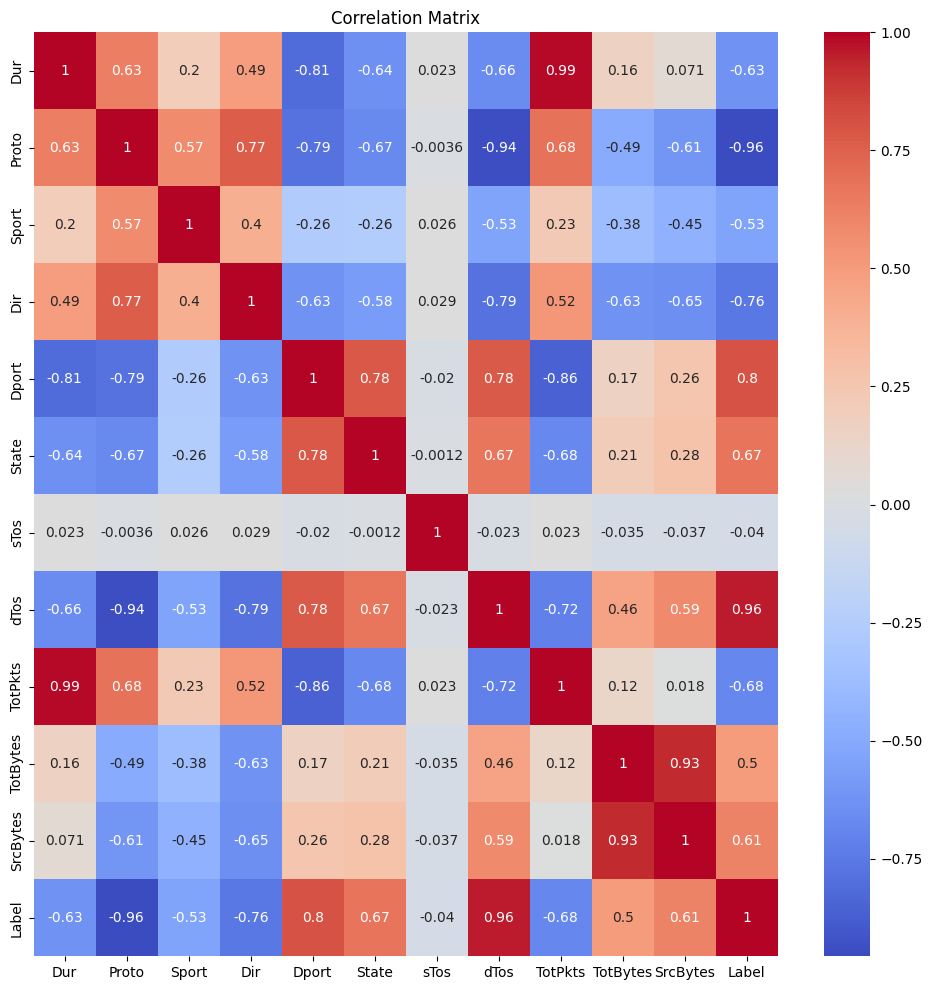

In [6]:
# plot correlation matrix to select features for visualization next
plt.figure(figsize=(12, 12))
correlation_matrix = preprocessed_data.drop(['StartTime', 'SrcAddr', 'DstAddr'], axis=1).corr('spearman')
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### 1a. Plot visualizations - Select and visualize two features for modeling the behavior of the infected host.

In [27]:
# preprocess data with no label encoding this time
vis_data = preprocess_data(data, date_fix=True, remove_background=True, label_enc=False)

# select data from normal traffic
normal_data = vis_data[vis_data['Label'] == '0']
print(normal_data.head())

# select data from botnet
botnet_data = vis_data[vis_data['Label'] == '1']
print(botnet_data.head())


                      StartTime          Dur Proto        SrcAddr  Sport  \
532  2011-08-18 10:19:15.693956  3587.569824   tcp  147.32.84.164  54784   
822  2011-08-18 10:19:18.143576   198.072739   tcp  147.32.84.164  56165   
842  2011-08-18 10:19:18.303590   197.928329   tcp  147.32.84.164  57965   
1021 2011-08-18 10:19:19.838272     0.000399   udp  147.32.84.170  45807   
1022 2011-08-18 10:19:19.839123     0.000400   udp  147.32.84.170  35380   

        Dir         DstAddr Dport  State  sTos  dTos  TotPkts  TotBytes  \
532     <?>  74.125.232.215   443  PA_PA   0.0   0.0     3049    978731   
822     <?>  74.125.232.197    80  FA_FA   0.0   0.0       14       924   
842     <?>  209.85.149.138    80  FA_FA   0.0   0.0       14       924   
1021    <->     147.32.80.9    53    CON   0.0   0.0        2       400   
1022    <->     147.32.80.9    53    CON   0.0   0.0        2       400   

      SrcBytes Label  
532     245317     0  
822        462     0  
842        462     0  


In [28]:
# an infected host is 147.32.84.165, let's filter for this one
infected_host = '147.32.84.165'
infected_host_data = botnet_data[(botnet_data['SrcAddr'] == infected_host) | (botnet_data['DstAddr'] == infected_host)]

# a benign host is 147.32.84.170, let's filter for this one
benign_host = '147.32.84.170'
benign_host_data = normal_data[(normal_data['SrcAddr'] == benign_host) | (normal_data['DstAddr'] == benign_host)]

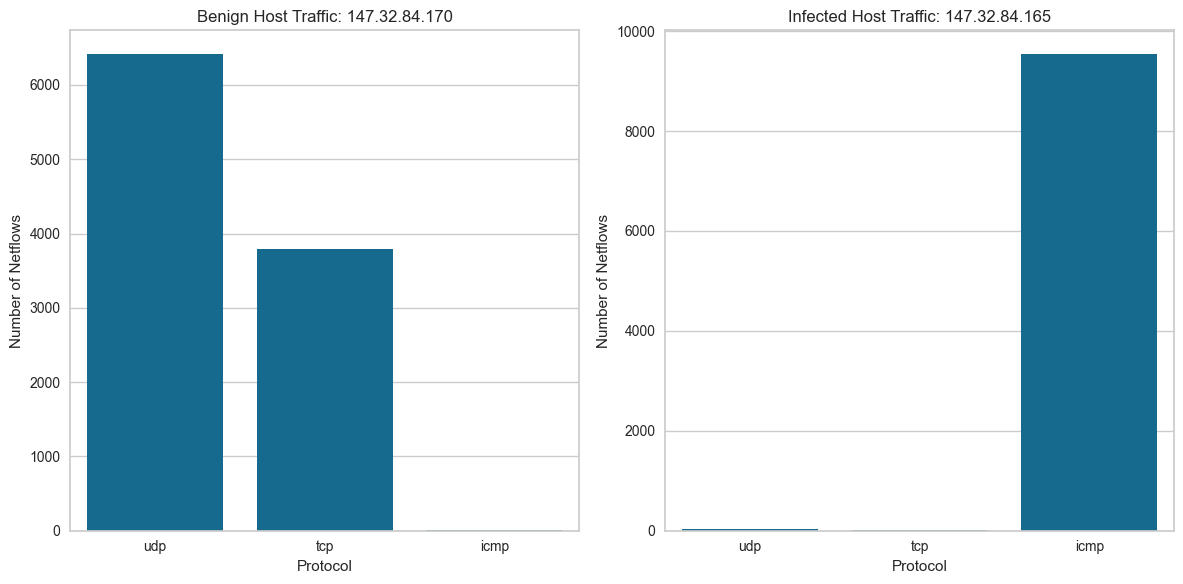

In [29]:
# plot the number of netflows per protocol for infected host and normal traffic
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(x='Proto', data=benign_host_data)
plt.title('Benign Host Traffic: 147.32.84.170')
plt.xlabel('Protocol')
plt.ylabel('Number of Netflows')

plt.subplot(1, 2, 2)
sns.countplot(x='Proto', data=infected_host_data)
plt.title('Infected Host Traffic: 147.32.84.165')
plt.xlabel('Protocol')
plt.ylabel('Number of Netflows')

plt.tight_layout()
plt.show()

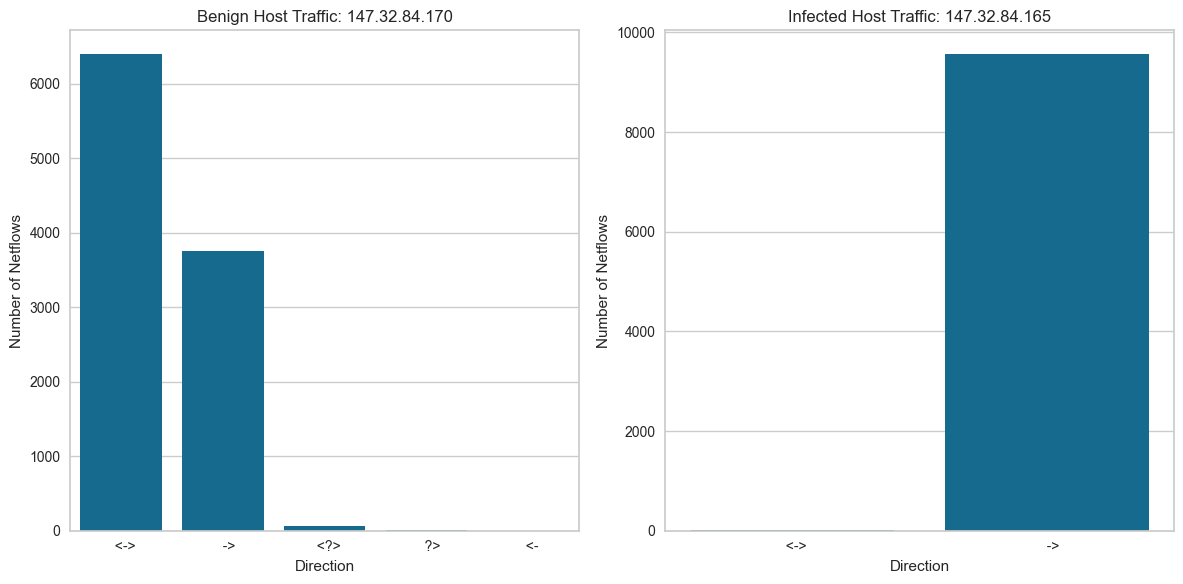

In [30]:
# plot the number of netflows per direction for infected host and normal traffic
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(x='Dir', data=benign_host_data)
plt.title('Benign Host Traffic: 147.32.84.170')
plt.xlabel('Direction')
plt.ylabel('Number of Netflows')

plt.subplot(1, 2, 2)
sns.countplot(x='Dir', data=infected_host_data)
plt.title('Infected Host Traffic: 147.32.84.165')
plt.xlabel('Direction')
plt.ylabel('Number of Netflows')

plt.tight_layout()
plt.show()

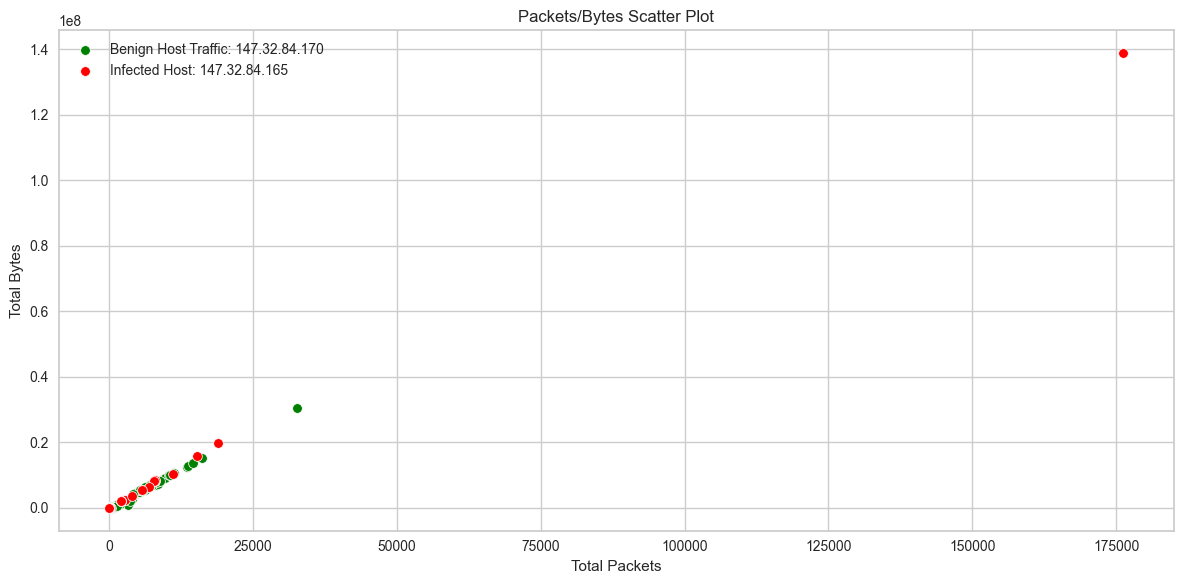

In [37]:
# scatter plot the total number of packets for infected host and normal traffic
plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
sns.scatterplot(x='TotPkts', y='TotBytes', data=benign_host_data, color='green', label='Benign Host Traffic: 147.32.84.170')
# plt.title('Benign Host Traffic: 147.32.84.170')
# plt.xlabel('Total Packets')
# plt.ylabel('Total Bytes')

# plt.subplot(1, 2, 2)
sns.scatterplot(x='TotPkts', y='TotBytes', data=infected_host_data, color='red', label='Infected Host: 147.32.84.165')
plt.title('Packets/Bytes Scatter Plot')
plt.xlabel('Total Packets')
plt.ylabel('Total Bytes')

plt.legend()
plt.tight_layout()
plt.show()

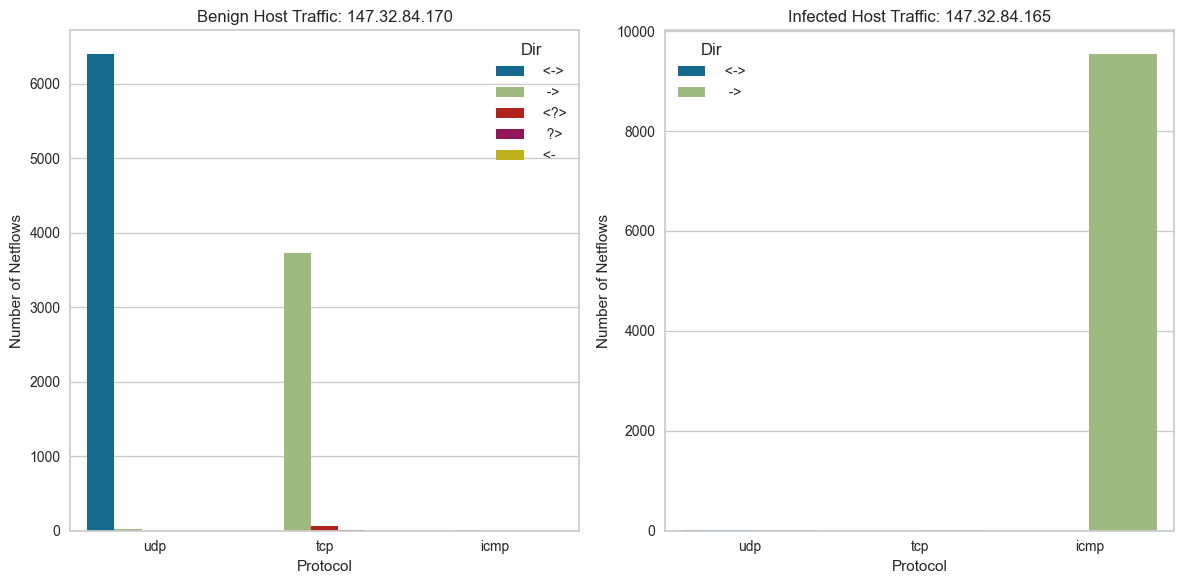

In [32]:
# combine the features into one plot - count of netflows per protocol and direction
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(x='Proto', hue='Dir', data=benign_host_data)
plt.title('Benign Host Traffic: 147.32.84.170')
plt.xlabel('Protocol')
plt.ylabel('Number of Netflows')

plt.subplot(1, 2, 2)
sns.countplot(x='Proto', hue='Dir', data=infected_host_data)
plt.title('Infected Host Traffic: 147.32.84.165')
plt.xlabel('Protocol')
plt.ylabel('Number of Netflows')

plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

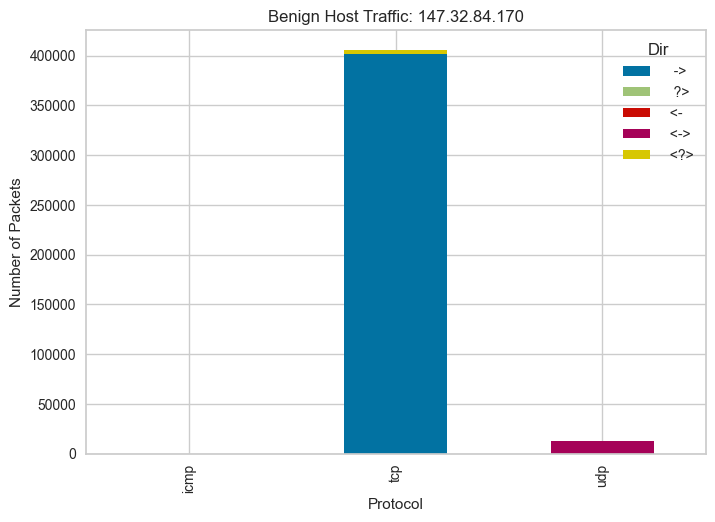

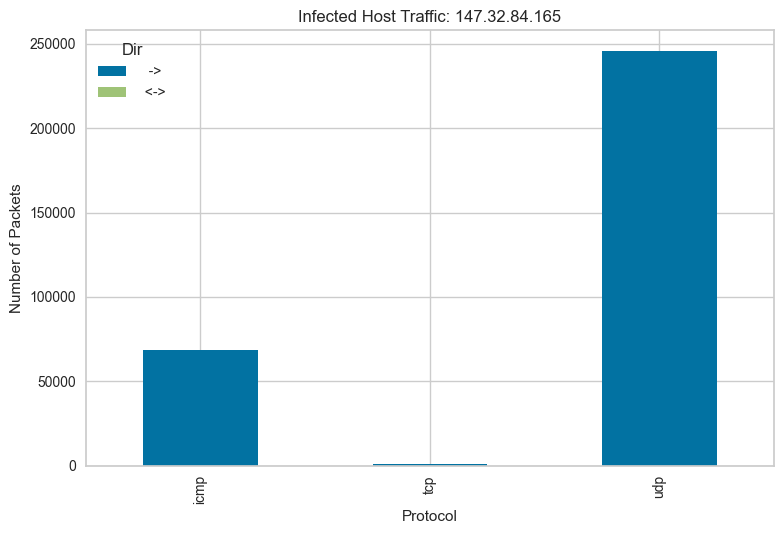

In [33]:
# plot total number of packets for each protocol-direction combination
plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
benign_host_data.groupby(['Proto', 'Dir'])['TotPkts'].sum().unstack().plot(kind='bar', stacked=True)
plt.title('Benign Host Traffic: 147.32.84.170')
plt.xlabel('Protocol')
plt.ylabel('Number of Packets')

# plt.subplot(1, 2, 2)
infected_host_data.groupby(['Proto', 'Dir'])['TotPkts'].sum().unstack().plot(kind='bar', stacked=True)
plt.title('Infected Host Traffic: 147.32.84.165')
plt.xlabel('Protocol')
plt.ylabel('Number of Packets')

plt.tight_layout()
plt.show()

### 1b. Discretize selected features

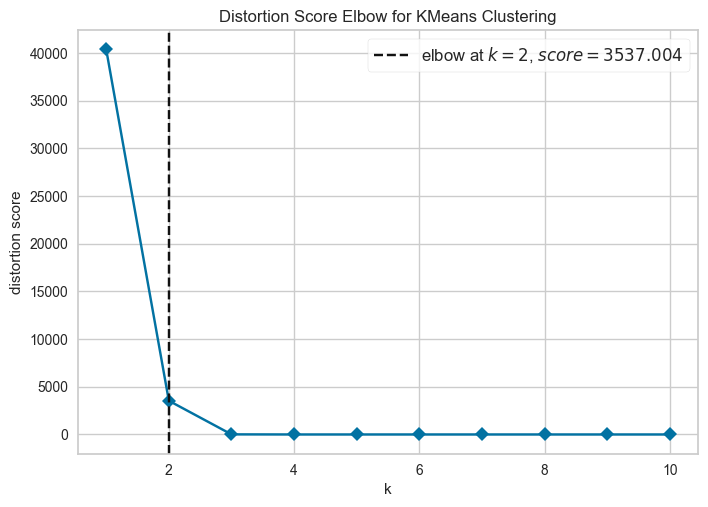

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [51]:
# Elbow technique to find optimal k for k-means clustering - protocol

model = KMeans()
elbow_visualizer = KElbowVisualizer(model,timings=False,k=(1,11))
# Fit the data to the visualizer
elbow_visualizer.fit(preprocessed_data[['Proto']])     
# Finalize and render the figure
elbow_visualizer.show()

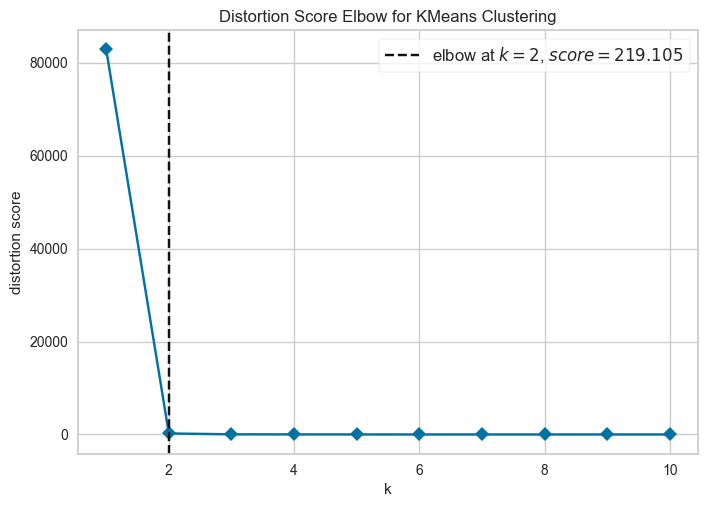

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [52]:
# Elbow technique to find optimal k for k-means clustering - total packets

model = KMeans()
elbow_visualizer = KElbowVisualizer(model,timings=False,k=(1,11))
# Fit the data to the visualizer
elbow_visualizer.fit(preprocessed_data[['Dir']])     
# Finalize and render the figure
elbow_visualizer.show()

In [53]:
# discretization with k-means clustering
def discretize_data(df, columns, k_values):
    
    data = df.copy()
    
    for col, k in zip(columns, k_values):
        kmeans = KMeans(n_clusters=k, random_state=0)
        data[col] = kmeans.fit_predict(data[[col]])
    
    return data

In [54]:
# discretize the selected features - protocol and total packets
discr_data = discretize_data(preprocessed_data, ['Proto', 'Dir'], [2, 2])
discr_data.head()

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
532,2011-08-18 10:19:15.693956,3587.569824,1,147.32.84.164,60058,1,74.125.232.215,426,57,0,0,3049,978731,245317,0
822,2011-08-18 10:19:18.143576,198.072739,1,147.32.84.164,60575,1,74.125.232.197,943,12,0,0,14,924,462,0
842,2011-08-18 10:19:18.303590,197.928329,1,147.32.84.164,61334,1,209.85.149.138,943,12,0,0,14,924,462,0
1021,2011-08-18 10:19:19.838272,0.000399,1,147.32.84.170,56632,1,147.32.80.9,592,4,0,0,2,400,74,0
1022,2011-08-18 10:19:19.839123,0.000400,1,147.32.84.170,52528,1,147.32.80.9,592,4,0,0,2,400,74,0


In [55]:
# function to combine discretized features into one
def combine_features(df, features):
    
    data = df.copy()

    code = 0
    space_size = 1
    for f in features:
        space_size = space_size*len(data[f].unique())

    for f in features:
        code += data[f]*space_size/len(data[f].unique())
        space_size = space_size/len(data[f].unique())

    return code

In [56]:
# combine discretized protocol and total packets into one feature
discr_data['Combined'] = combine_features(discr_data, ['Proto', 'Dir'])
discr_data.head()

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label,Combined
532,2011-08-18 10:19:15.693956,3587.569824,1,147.32.84.164,60058,1,74.125.232.215,426,57,0,0,3049,978731,245317,0,3.0
822,2011-08-18 10:19:18.143576,198.072739,1,147.32.84.164,60575,1,74.125.232.197,943,12,0,0,14,924,462,0,3.0
842,2011-08-18 10:19:18.303590,197.928329,1,147.32.84.164,61334,1,209.85.149.138,943,12,0,0,14,924,462,0,3.0
1021,2011-08-18 10:19:19.838272,0.000399,1,147.32.84.170,56632,1,147.32.80.9,592,4,0,0,2,400,74,0,3.0
1022,2011-08-18 10:19:19.839123,0.000400,1,147.32.84.170,52528,1,147.32.80.9,592,4,0,0,2,400,74,0,3.0


In [57]:
# check unique values for the combined feature
print(len(discr_data['Combined'].unique()), list(discr_data['Combined'].unique()))

4 [3.0, 2.0, 1.0, 0.0]


In [58]:
# check combined feature for an infected host and a benign host
# an infected host is 147.32.84.165, let's filter for this one
infected_host = '147.32.84.165'
infected_host_data = discr_data[((discr_data['SrcAddr'] == infected_host) | (discr_data['DstAddr'] == infected_host)) & (discr_data['Label'] == '1')]

# a benign host is 147.32.84.170, let's filter for this one
benign_host = '147.32.84.170'
benign_host_data = discr_data[((discr_data['SrcAddr'] == benign_host) | (discr_data['DstAddr'] == benign_host)) & (discr_data['Label'] == '0')]

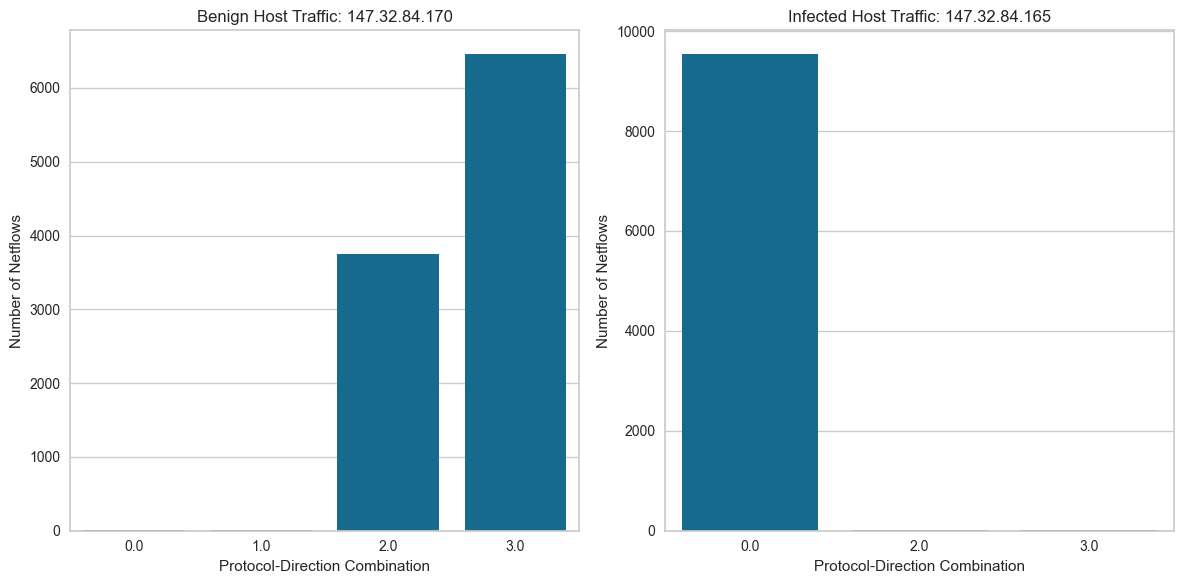

In [59]:
# plot the combined feature for infected host and normal traffic
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(x='Combined', data=benign_host_data)
plt.title('Benign Host Traffic: 147.32.84.170')
plt.xlabel('Protocol-Direction Combination')
plt.ylabel('Number of Netflows')

plt.subplot(1, 2, 2)
sns.countplot(x='Combined', data=infected_host_data)
plt.title('Infected Host Traffic: 147.32.84.165')
plt.xlabel('Protocol-Direction Combination')
plt.ylabel('Number of Netflows')

plt.tight_layout()
plt.show()

### 1c. Answers and explanation

First, we are looking at the bottom horizontal line of the correlation matrix to find features with strong relationships with the Label (benign/infected). We can see that the protocol, direction and total packets showcase strong/semi-strong negative correlation with the Label, so we focus on these. We select a benign and an infected host and analyze their features.

1. **Protocol**: We observe that the infected host uses almost solely the ICMP protocol, while the benign host uses mostly UDP and TCP.

2. **Direction**: The infected host communication is almost always one-way, while for the benign host it is more often both-ways.

3. **Total Packets**: Here, there is a big overlap between the infected and the benign host, as for both, communication involves up to 20k packets containing up to 20 MBytes of information. Except of one specific case, where the infected host sent around 175k packets, there is no clear distinction to be made.

We then went on to discretize the protocol and direction of communication. We used the Elbow method to find the optimal k clusters for each of them. After discretization and combining the features, as in the provided paper by Pellegrino, the new combined feature has 4 unique values. Our final plot shows that the combination of protocol-direction could be highly effective for recognizing infected hosts.


## 2. Sketching task – 1/2 A4 (Individual, 10 Points)

### 2a. COUNT-MIN sketch


In [64]:
# get n-grams from the combined discretized features
combined_ngrams = list(ngrams(discr_data['Combined'], 3))
print("First 10 3-grams of the combined discretized features:")
print(combined_ngrams[:10])

First 10 3-grams of the combined discretized features:
[(3.0, 3.0, 3.0), (3.0, 3.0, 3.0), (3.0, 3.0, 3.0), (3.0, 3.0, 2.0), (3.0, 2.0, 3.0), (2.0, 3.0, 3.0), (3.0, 3.0, 3.0), (3.0, 3.0, 3.0), (3.0, 3.0, 3.0), (3.0, 3.0, 3.0)]


In [67]:
# show unique 3-grams
unique_ngrams = list(set(combined_ngrams))
print("Number of unique 3-grams:", len(unique_ngrams))

# count the number of occurrences of each 3-gram
ngram_counts = {ngram: combined_ngrams.count(ngram) for ngram in unique_ngrams}
print("\nFirst 10 3-grams with their counts:")
for i in range(10):
    print(list(ngram_counts.items())[i])

Number of unique 3-grams: 64

First 10 3-grams with their counts:
((2.0, 0.0, 2.0), 87)
((0.0, 1.0, 0.0), 11)
((2.0, 2.0, 2.0), 1898)
((2.0, 1.0, 0.0), 12)
((0.0, 1.0, 3.0), 5)
((0.0, 3.0, 0.0), 39)
((2.0, 1.0, 3.0), 17)
((0.0, 3.0, 3.0), 74)
((3.0, 2.0, 1.0), 64)
((1.0, 2.0, 2.0), 19)


In [88]:
# implementation of Count-Min sketch
class CountMinSketch:
    
    def __init__(self, width, depth):
        self.width = width
        self.depth = depth
        self.table = np.zeros((depth, width))

        # pairwise independent hash functions
        self.hash_functions = [(np.random.randint(1, 10**6), np.random.randint(0, 10**6)) for _ in range(depth)]
    
    def update(self, key, count=1):
        for i in range(self.depth):
            hash_value = hash(key) ^ self.hash_functions[i][0]
            index = hash_value % self.width
            self.table[i][index] += count
    
    def query(self, key):
        min_count = np.inf
        for i in range(self.depth):
            hash_value = hash(key) ^ self.hash_functions[i][0]
            index = hash_value % self.width
            min_count = min(min_count, self.table[i][index])
        return min_count
    

# mean squared error function for Count-Min sketch frequencies
def mean_abs_error(true_counts, estimated_counts):
    return np.mean(abs(true_counts - estimated_counts))

# function for creating a Count-Min sketch with given width and depth
# returns the predicted frequencies of the 3-grams
def create_count_min_sketch(data, unique_ngrams, width, depth):
    
    # create the Count-Min sketch
    cms = CountMinSketch(width, depth)
    
    # update the sketch with the 3-grams
    for ngram in data:
        cms.update(ngram)
    
    estimated_counts = {}
    for ngram in unique_ngrams:
        estimated_counts[ngram] = cms.query(ngram)
    
    return estimated_counts

In [98]:
# NOTE: takes about 1.5 minutes to run
# calculate approximate frequencies of the 3-grams using Count-Min sketch
# for different widths and depths

widths = [4, 8, 12, 16, 20, 24, 28, 32]
depths = [2, 4, 6, 8, 10, 12, 14, 16]

freq_errors = np.zeros((len(widths), len(depths)))

for i, width in enumerate(widths):
    for j, depth in enumerate(depths):
        estimated_counts = create_count_min_sketch(combined_ngrams, list(ngram_counts.keys()), width, depth)
        # print(estimated_counts[:10])
        # print(np.array(list(ngram_counts.values())[:10]))
        freq_errors[i, j] = mean_abs_error(np.array(list(ngram_counts.values())), np.array(list(estimated_counts.values())))

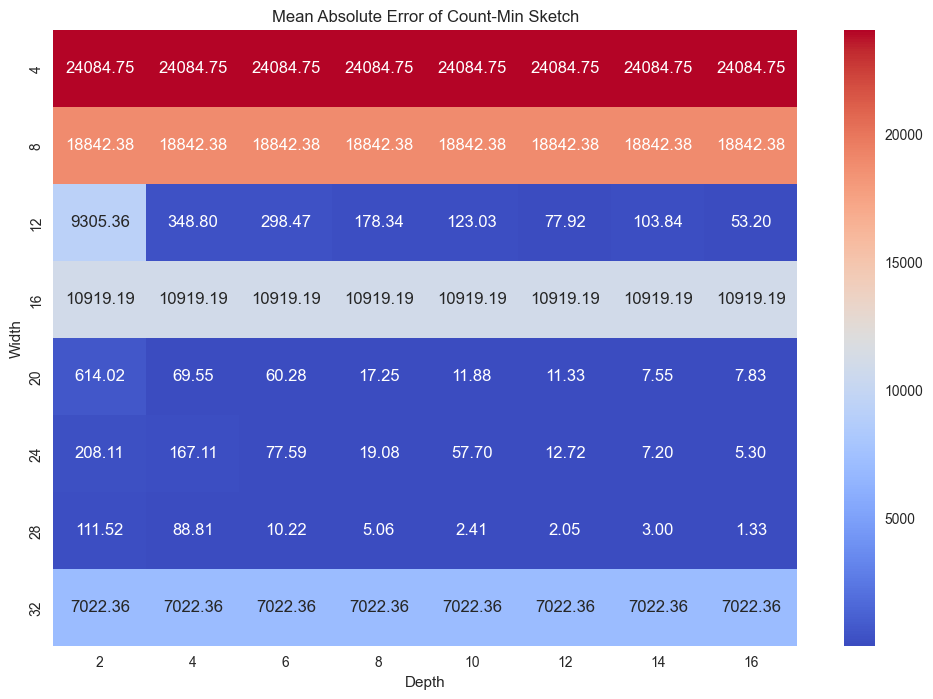

In [102]:
# plot heatmap of mean squared errors for different widths and depths
plt.figure(figsize=(12, 8))
sns.heatmap(freq_errors, annot=True, fmt=".2f", xticklabels=depths, yticklabels=widths, cmap='coolwarm')
plt.title('Mean Absolute Error of Count-Min Sketch')
plt.xlabel('Depth')
plt.ylabel('Width')
plt.show()

In [103]:
# check for a specific combination the top 10 most frequent 3-grams
# and their estimated frequencies using Count-Min sketch

width, depth = 24, 2
estimated_counts = create_count_min_sketch(combined_ngrams, list(ngram_counts.keys()), width, depth)
sorted_estimated_counts = {k: v for k, v in sorted(estimated_counts.items(), key=lambda item: item[1], reverse=True)}

print("Top 10 most frequent 3-grams and their estimated frequencies using Count-Min sketch:")
for i, (ngram, count) in enumerate(sorted_estimated_counts.items()):
    if i == 10:
        break
    print(ngram, count)

Top 10 most frequent 3-grams and their estimated frequencies using Count-Min sketch:
(0.0, 0.0, 0.0) 105552.0
(3.0, 3.0, 3.0) 3176.0
(3.0, 0.0, 2.0) 2984.0
(2.0, 0.0, 3.0) 2984.0
(3.0, 3.0, 2.0) 2963.0
(0.0, 3.0, 0.0) 2862.0
(2.0, 3.0, 3.0) 2862.0
(1.0, 3.0, 2.0) 2862.0
(3.0, 1.0, 0.0) 2862.0
(2.0, 1.0, 2.0) 2490.0


In [104]:
# actual frequencies of the above 3-grams
print("\nActual frequencies of the top 10 most frequent 3-grams:")
for i, (ngram, count) in enumerate(sorted(ngram_counts.items(), key=lambda item: item[1], reverse=True)):
    if i == 10:
        break
    print(ngram, count)


Actual frequencies of the top 10 most frequent 3-grams:
(0.0, 0.0, 0.0) 105428
(3.0, 3.0, 3.0) 3166
(3.0, 3.0, 2.0) 2944
(2.0, 3.0, 3.0) 2818
(3.0, 2.0, 3.0) 2471
(2.0, 2.0, 2.0) 1898
(3.0, 2.0, 2.0) 573
(2.0, 2.0, 3.0) 554
(2.0, 0.0, 0.0) 255
(1.0, 1.0, 1.0) 236


### 2b. Analysis and answers to the questions

In terms of space and time complexity, Count-Min estimation is definitely an efficient option. For calculating the actual frequency of the 3-grams, we would need as much space as the amount of unique 3-grams, which in our case is 64. On the contrary, by selecting the right combination of width and depth for Count-Min sketch, we can fit the frequencies in an even smaller space. For instance, above, we have selected to show the top results for width=24 and depth=2, requiring a space of 48. Then, for the baseline case, we would need to search across the selected datastructure with a suitable algorithm to find the requested 3-gram. This could be done with binary search in O(logN). With Count-Min sketch, however, this can be done in O(1). 

Finally, regarding performance, we can look also at our heatmap, focusing on width-depth combinations that do not surpass 64 (supposing we want a smaller space than the baseline case). We can see that there is a significant mean absolute error between the actual and the approximated frequencies of the 3-grams. Based on its preferences, the user would have to resolve the performance/space-time efficiency tradeoff and select the parameters that suit him better. Just above, we printed the top 3-grams, based on Count-Min sketch, and the actual top 3-grams with their actual frequency. We can see that there are some misses from the Count-Min sketch, while its errors are overestimations of the actual frequencies. I would suggest the usage of Count-Min sketch when there are very restricting computational limitations and a reasonable approximation error is acceptable.  

## 3. Min-wise locality sensitive hashing task – 1/2 A4 (Individual, 10 Points)

### 3a. Implementation

### 3b. Analysis and answers to the questions

## 4.Botnet profiling and fingerprinting task – 1 A4 (5 Points)

### 4a. Learn a sequential model, profiling and fingerprinting

### 4b. Analysis and answers to the questions.

## 5. Bonus Task 1/2 A4 (5 Points)

### 5a. Provide implementation and analysis.